In [1]:
from matplotlib import pyplot as plt
import datetime
import numpy as np

In [2]:
def get_ts(line):
	tmp = line.split()
	dt = datetime.datetime.strptime(tmp[0], "%H:%M:%S.%f")
	return dt

def parse_file(fname):
    f = open(fname, "r")
    binded = {}
    delete_ts = []
    added_ts = []
    insert_ts = []
    bind_ts = []
    fetch_ts = []
    fetch_count = []
    net_ts = []
    insert_str = "Insert/Update pod"
    delete_str = "Deleting pod"
    bind_str = "EmulatedPodToNodeBinder - Binding"
    fetch_str = "Fetchcount"
    added_str = "pod added"
    for line in f.readlines():
        if "system-pod" in line or "-resource-dummy" in line:
            continue
        if added_str in line:
            added_ts.append(get_ts(line))
        if insert_str in line:
            i1 = line.index(insert_str)
            tmp = line[i1+len(insert_str):].split(",")
            pid = tmp[0].lstrip().rstrip()
            name = tmp[1].lstrip().split()[0]
            insert_ts.append(get_ts(line))   
            net_ts.append(insert_ts[-1])      
        if delete_str in line:
            i1 = line.index(delete_str)
            tmp = line[i1+len(delete_str):].split(",")[0]
            pid = tmp.split(":")[1].lstrip().rstrip()
            name = tmp.split("(")[0].strip()
            delete_ts.append(get_ts(line))
            net_ts.append(delete_ts[-1])
        if bind_str in line:
            i1 = line.index(bind_str)
            tmp = line[i1+len(insert_str):].split(")")[0]
            pid = tmp.split("uid:")[1].strip()
            name = (tmp.split("(")[0]).split("/")[1]
            binded[pid] = name
            bind_ts.append(get_ts(line))
        if fetch_str in line:
            tmp = line.split()
            fetch_ts.append(get_ts(line))
            fetch_count.append(int(tmp[-1]))
    f.close()

    return insert_ts, added_ts, delete_ts, bind_ts, fetch_ts, fetch_count

In [11]:
def plot_trace(root, method, n, p):
    fname = "%s/%s-n%d-p%d.txt" % (root, method, n, p)
    insert_ts, added_ts, delete_ts, bind_ts, fetch_ts, fetch_count = parse_file(fname)

    plt.figure(figsize=(12,8))
    plt.plot(insert_ts, range(len(insert_ts)), label='insert', linestyle='--')
    plt.plot(added_ts, range(len(added_ts)), label='added', linestyle='--')
    plt.plot(delete_ts, range(len(delete_ts)), label='delete', linestyle='--')
    plt.plot(bind_ts, range(len(bind_ts)), label='bind')
    plt.plot(fetch_ts, fetch_count, label='fetchcount')
    plt.legend(fontsize=14, frameon=False)
    plt.ylim(0, 2500)
    plt.title("%s(nodes:%d, anti-affinity:%d)" % (method, n, p), fontsize=18)
    plt.savefig("plots/n%d-p%d-%s.png" % (n, p, method), dpi=300)

In [4]:
scope_args = '"-n %d -f v2-cropped.txt -c 100 -m 200 -t 100 -s 100 -p %d -S"'
orig_args = '"-n %d -f v2-cropped.txt -c 100 -m 200 -t 100 -s 100 -p %d"'
template = './gradlew runBenchmark --args=%s | sed $"s,\x1b\\[[0-9;]*[a-zA-Z],,g" &> %s'

def gen_cmd(root, method, n, p):
    outfile = "%s/%s-n%d-p%d.txt" % (root, method, n, p)
    if method == 'orig':
        args = orig_args % (n, p)
    else:
        args = scope_args % (n, p)
    cmd = template % (args, outfile)
    return cmd

In [5]:
# Root directory of the log files 
root = "/Users/krong/Desktop/dcm-exp"

In [20]:
# Generate all run commands 
f = open("scope_bench.sh", "w")
for method in ["orig", "scope"]:
    for n in [500, 5000, 50000]:
        for p in [0, 50, 100]:
            cmd = gen_cmd(root, method, n, p)
            f.write('%s\n\n' % cmd)
f.close()

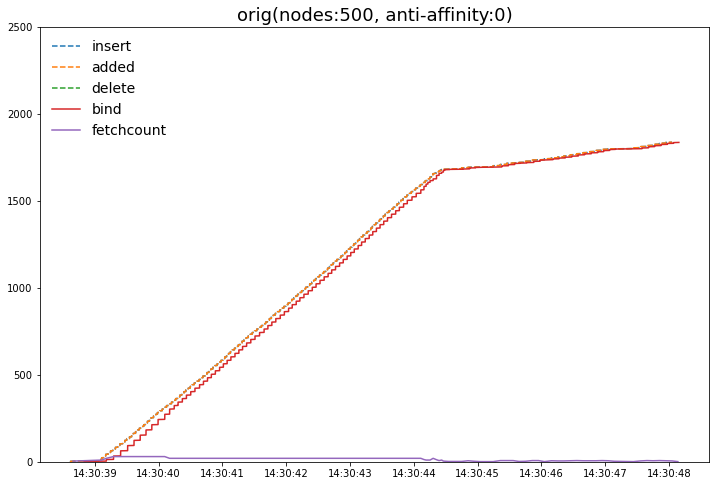

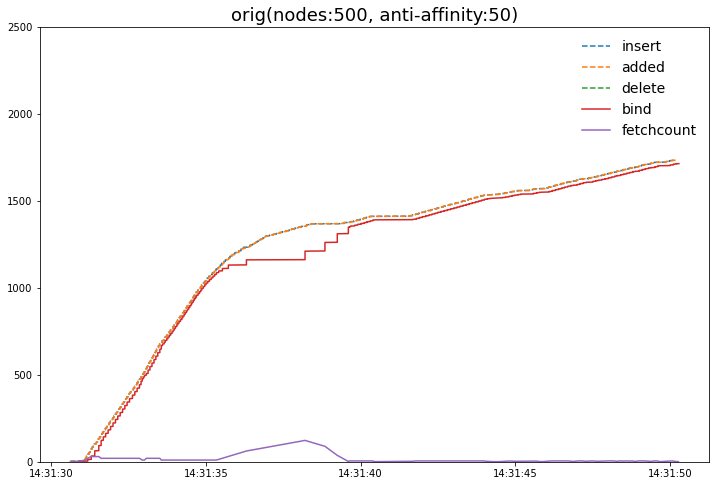

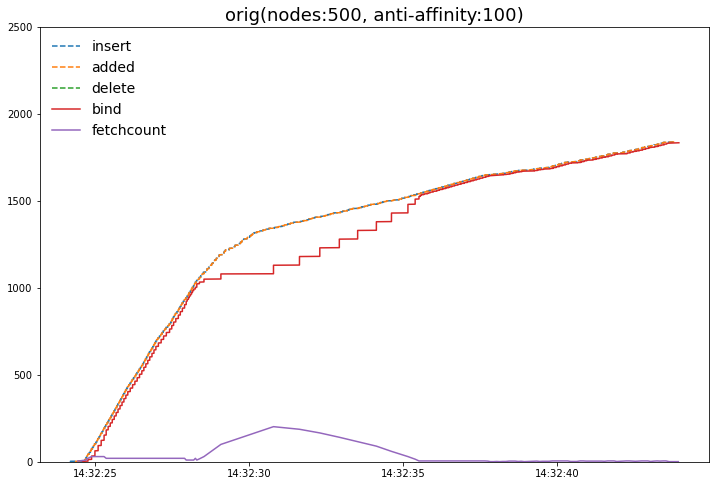

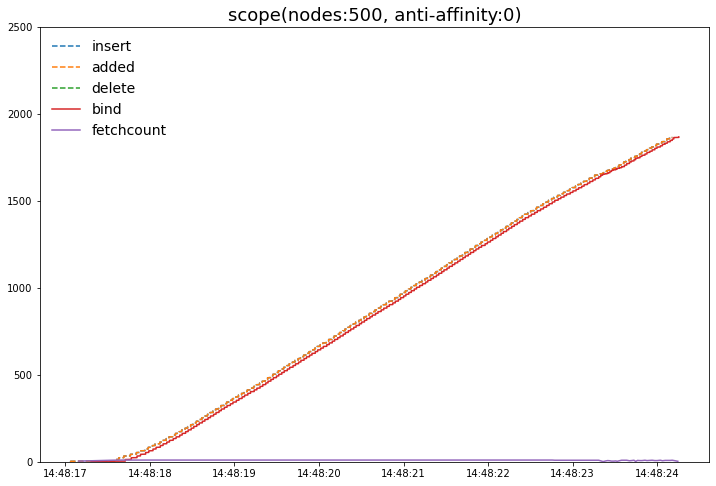

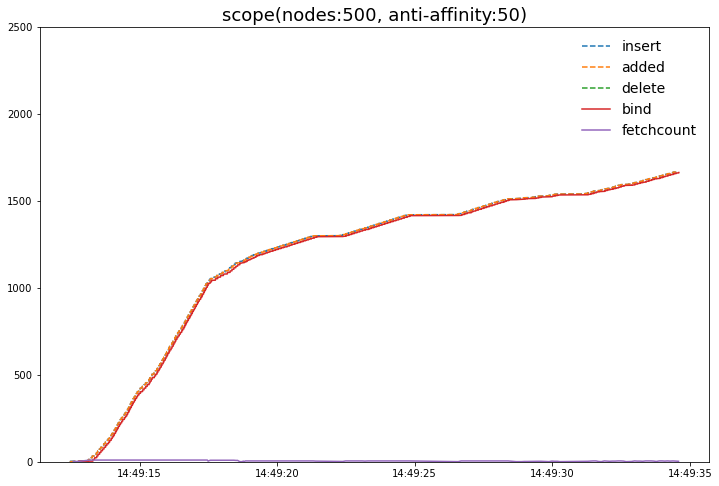

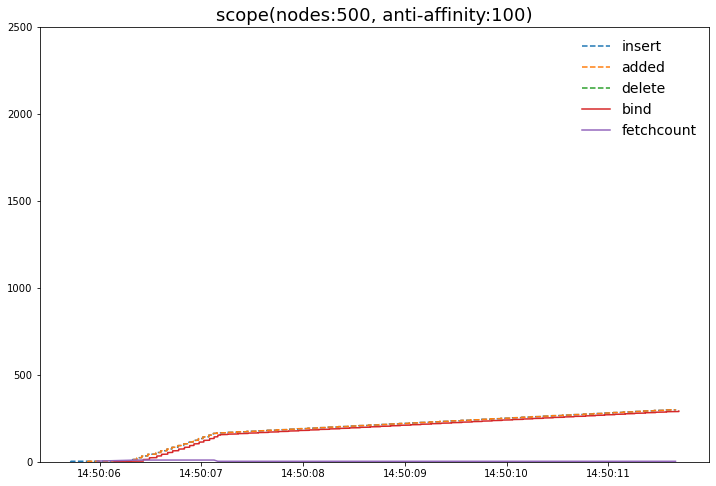

In [15]:
# Plot traces
for method in ["orig", "scope"]:
    for n in [500]:
        for p in [0, 50, 100]:
            plot_trace(root, method, n, p)